In [1]:
import traceback
import json
import os
import shutil
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pynwb import NWBHDF5IO

import spikeinterface
import spikeinterface.full as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.qualitymetrics as sqm
import spikeinterface.postprocessing as spost


from pathlib import Path

import probeinterface as pi
from probeinterface import generate_linear_probe
from probeinterface.plotting import plot_probe


ss.Kilosort3Sorter.set_kilosort3_path('./sorters_packages/Kilosort')
ss.IronClustSorter.set_ironclust_path('./sorters_packages/ironclust')


def fixparams(sorter):
    '''
    Changes the necessary parameters according to the specific sorter selected.
    
    '''
   
    params = ss.get_default_sorter_params(sorter)

    if sorter == 'mountainsort4':
        params['filter'] = False

    if sorter == 'ironclust':
        params['filter'] = False

    if sorter == 'herdingspikes':
        params['filter'] = False

    if sorter == 'tridesclous':
        params['freq_max'] = 4000

    if sorter == 'hdsort':
        params['filter'] = False

    if sorter == 'tridesclous2':
        params['filtering']['freq_max'] = 4000
        
    return params


Setting KILOSORT3_PATH environment variable for subprocess calls to: /gpfs/bbp.cscs.ch/project/proj68/home/imbeni/SpikeSortingTrials/sorters_packages/Kilosort
Setting IRONCLUST_PATH environment variable for subprocess calls to: /gpfs/bbp.cscs.ch/project/proj68/home/imbeni/SpikeSortingTrials/sorters_packages/ironclust


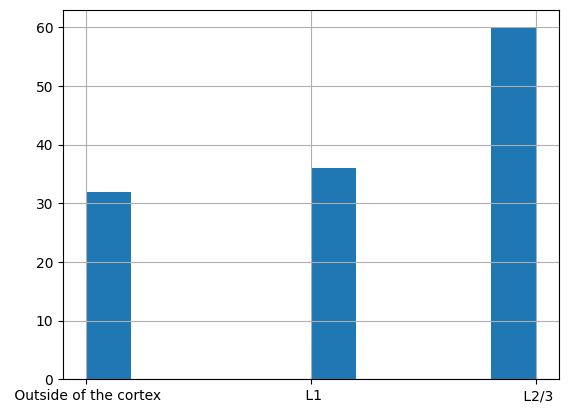

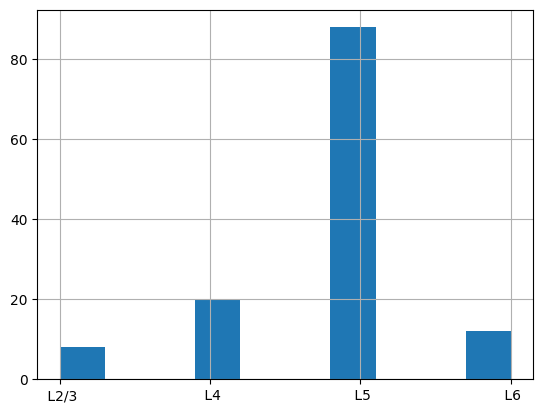

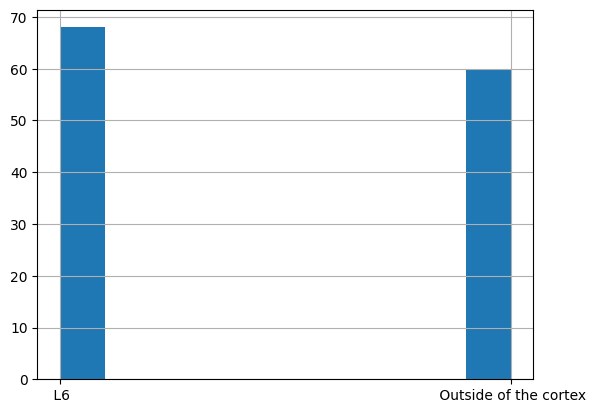

In [2]:
nwbpath = '/gpfs/bbp.cscs.ch/project/proj68/home/imbeni/dataset/horvath/Rat01/Insertion1/'
output_folder = '1_horvath/'
name = 'r1ins1'
outpath = output_folder + name +'/'
recs = {}
for i in [1,2,3]:
    io = NWBHDF5IO(nwbpath + 'Rat01_Insertion1_Depth'+str(i)+'.nwb', mode="r")
    nwbfile = io.read()
    df = nwbfile.electrodes.to_dataframe()
    location = df.location.apply(lambda x: x.decode("utf-8").split(',')[-1])
    location.hist()
    plt.show()

    rec = se.NwbRecordingExtractor(nwbpath + 'Rat01_Insertion1_Depth'+str(i)+'.nwb')
    recs[i]= rec

In [3]:
for rec in recs.items():
    pprint(rec)

(1,
 NwbRecordingExtractor: 128 channels - 1 segments - 20.0kHz - 3606.552s
  file_path: /gpfs/bbp.cscs.ch/project/proj68/home/imbeni/dataset/horvath/Rat01/Insertion1/Rat01_Insertion1_Depth1.nwb)
(2,
 NwbRecordingExtractor: 128 channels - 1 segments - 20.0kHz - 3688.668s
  file_path: /gpfs/bbp.cscs.ch/project/proj68/home/imbeni/dataset/horvath/Rat01/Insertion1/Rat01_Insertion1_Depth2.nwb)
(3,
 NwbRecordingExtractor: 128 channels - 1 segments - 20.0kHz - 3603.096s
  file_path: /gpfs/bbp.cscs.ch/project/proj68/home/imbeni/dataset/horvath/Rat01/Insertion1/Rat01_Insertion1_Depth3.nwb)


In [4]:
print('Installed sorters', ss.installed_sorters())

RUNNING SHELL SCRIPT: /nvme/imbeni/856205/tmp_shellscript7mmoa8nv/script.sh
RUNNING SHELL SCRIPT: /nvme/imbeni/856205/tmp_shellscripts979otx3/script.sh
RUNNING SHELL SCRIPT: /nvme/imbeni/856205/tmp_shellscriptdh3tk7ae/script.sh
RUNNING SHELL SCRIPT: /nvme/imbeni/856205/tmp_shellscriptj4e0gtdx/script.sh
RUNNING SHELL SCRIPT: /nvme/imbeni/856205/tmp_shellscript7oxsgdcg/script.sh
RUNNING SHELL SCRIPT: /nvme/imbeni/856205/tmp_shellscriptec5797v1/script.sh
RUNNING SHELL SCRIPT: /nvme/imbeni/856205/tmp_shellscript7rqosp_2/script.sh
RUNNING SHELL SCRIPT: /nvme/imbeni/856205/tmp_shellscriptfow_kths/script.sh
Installed sorters ['herdingspikes', 'ironclust', 'kilosort3', 'mountainsort4', 'spykingcircus2', 'tridesclous', 'tridesclous2']


/gpfs/bbp.cscs.ch/data/scratch/proj68/milo/lfp/lib/python3.9/site-packages/spikeinterface/sorters/waveclus/waveclus.py:125: ResourceWarning: unclosed file <_io.TextIOWrapper name=62 encoding='UTF-8'>
  if cls.check_compiled():
/gpfs/bbp.cscs.ch/data/scratch/proj68/milo/lfp/lib/python3.9/site-packages/spikeinterface/sorters/waveclus/waveclus_snippets.py:83: ResourceWarning: unclosed file <_io.TextIOWrapper name=62 encoding='UTF-8'>
  if cls.check_compiled():


In [5]:
output_folder = '1_horvath/'
name = 'r1ins1'
outpath = output_folder + name +'/'

nwbpath = '/gpfs/bbp.cscs.ch/project/proj68/home/imbeni/dataset/horvath/Rat01/Insertion1/'

NWB file name,NWB file size (GB),Recording duration (min),Cortical area,Single unit yield,Average signal-to-noise ratio of single units,Power spectral density at 50 Hz (dB/Hz),50 Hz/49 Hz ratio,RMS noise level (300 - 6000 Hz),RMS signal level (300 - 6000 Hz)
Rat01_Insertion1_Depth1,13.02,60.11,S1HL,66,12.88,47.39,1.83,8.61,12.22
Rat01_Insertion1_Depth2,13.39,61.48,S1HL,91,8.29,47.33,1.70,8.57,18.38
Rat01_Insertion1_Depth3,13.01,60.05,S1HL,50,8.54,47.28,1.78,9.58,15.55

metrics = {
    "num_spikes" : compute_num_spikes,
    "firing_rate" : compute_firing_rate,
    "presence_ratio" : compute_presence_ratio,
    "snr" : compute_snrs,
    "isi_violation" : compute_isi_violations,
    "amplitude_cutoff" : compute_amplitudes_cutoff, 
    'mahalanobis_metrics' : mahalanobis_metrics,
    'd_prime' : lda_metrics,
    'nearest_neighbor' : nearest_neighbors_metrics,
    'nn_isolation' : nearest_neighbors_isolation,
    'nn_noise_overlap' : nearest_neighbors_noise_overlap}

In [6]:
io = NWBHDF5IO(nwbpath + 'Rat01_Insertion1_Depth1.nwb', mode="r")
nwbfile = io.read()
rec = se.NwbRecordingExtractor(nwbpath + 'Rat01_Insertion1_Depth1.nwb')
fs = rec.get_sampling_frequency()

In [7]:
 nwbfile.electrodes.to_dataframe().location.iloc[0].decode("utf-8")

'S1HL, Outside of the cortex'

In [8]:
rec.get_channel_gains()

array([195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 1950

In [9]:
list(rec.get_property_keys())

['gain_to_uV',
 'offset_to_uV',
 'contact_vector',
 'location',
 'group',
 'imp',
 'brain_area',
 'filtering']

In [10]:
for key in list(rec.get_property_keys()):
    print(rec.get_property(key)[0])

195000.0
0.0
(0, 16., 707.5, 'circle', 1., '', '', 0, 'um', 1., 0., 0., 1.)
[ 16.  707.5]
0
b'N'
b'S'
b'B'


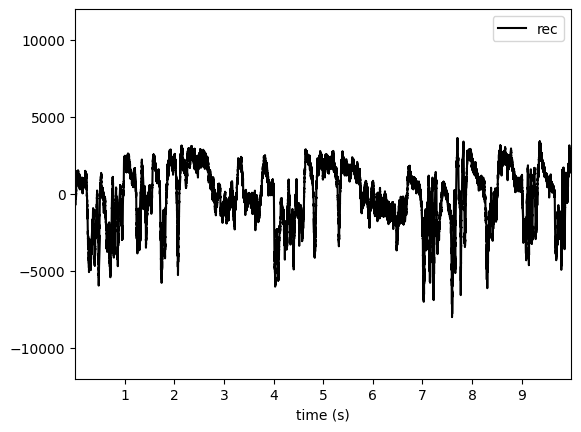

In [11]:
sw.plot_timeseries(rec, channel_ids = [120], time_range = [0,10])

In [12]:
reccut = rec.frame_slice(start_frame=0*fs, end_frame=20*fs)
reccut = si.bandpass_filter(reccut, freq_min=300, freq_max=6000)
reccut = si.common_reference(reccut, reference='global', operator='median')

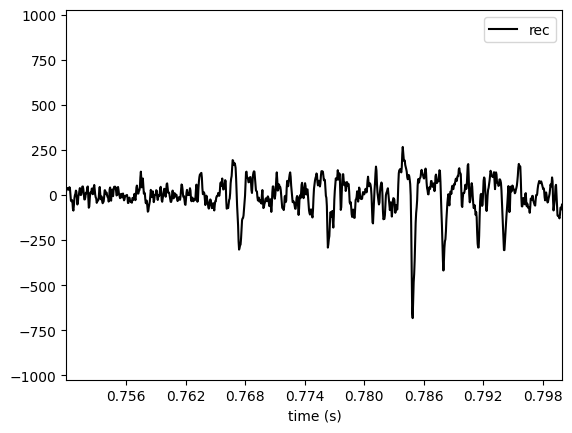

In [13]:

wg = sw.plot_timeseries(reccut, channel_ids = [120],time_range = [0.75,0.80]) #time_range = [8.75,8.80])
plt.savefig('fig.jpg')

(<matplotlib.collections.PolyCollection at 0x7ffebf418be0>, None)

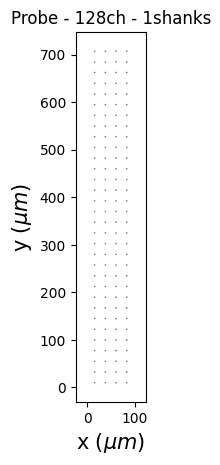

In [14]:
probe = rec.get_probe()
plot_probe(probe)

herdingspikes
11
508.8181818181818


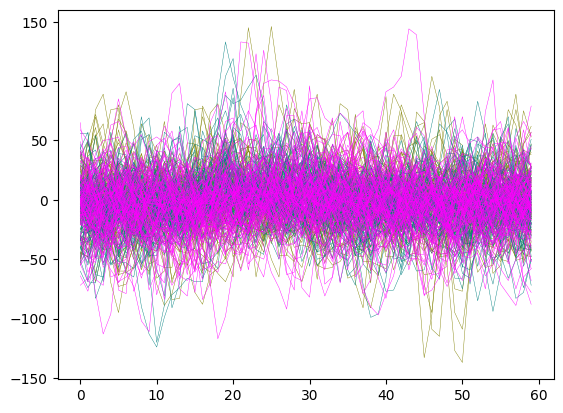

Done!
ironclust
9
10679.777777777777


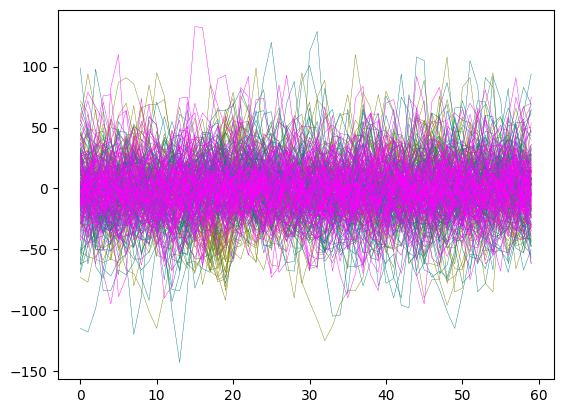

Done!
mountainsort4
mountainsort4 failed
Done!
spykingcircus2
7
61.857142857142854


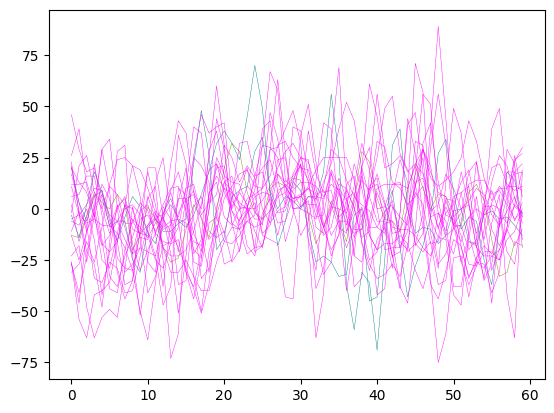

Done!
tridesclous
13
360.3076923076923


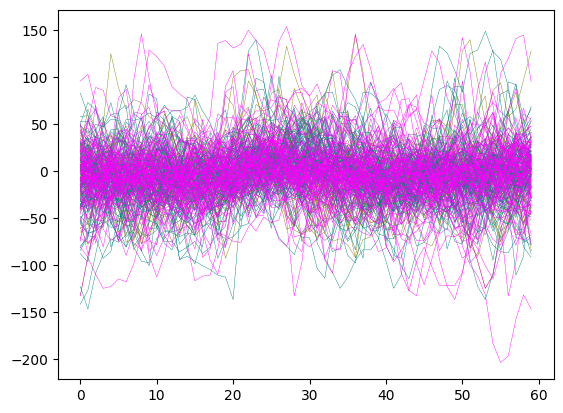

Done!
tridesclous2
22
742.1818181818181


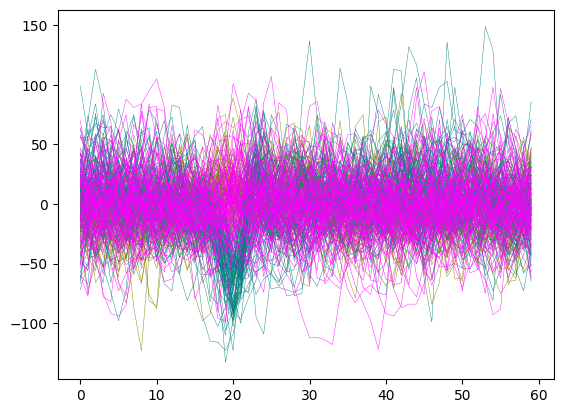

Done!


In [15]:
inpath = '/gpfs/bbp.cscs.ch/project/proj68/home/imbeni/SortingRunsMPI/1_horvath/r1ins1d1/'
recordingpath = inpath + 'rec_20'
recording = spikeinterface.load_extractor(recordingpath)

sorter = 'herdingspikes'
for sorter in ['herdingspikes','ironclust', 'mountainsort4', 'spykingcircus2', 'tridesclous', 'tridesclous2']:
    print(sorter)
    try:
        sortingpath = inpath + str(sorter) + '_out_spiketrains_20'
        sorting = spikeinterface.load_extractor(sortingpath)
        ids = sorting.get_unit_ids()
        print(len(ids))
        print(np.mean([len(sorting.get_unit_spike_train(unit_id=idd)) for idd in ids]))
        we_folder = sorter +'_wfs_20'

        Path(inpath + 'waveforms/'+ we_folder).mkdir(parents=True, exist_ok=True)

        we = si.extract_waveforms(recording, sorting, we_folder,
                                  load_if_exists=False, overwrite=True,
                                  ms_before=1, ms_after=2., max_spikes_per_unit=100)

        colors = ['Olive', 'Teal', 'Fuchsia']

        fig, ax = plt.subplots()
        for i, unit_id in enumerate(sorting.unit_ids[:3]):
            wf = we.get_waveforms(unit_id)
            color = colors[i]
            ax.plot(wf[:, :, 8].T, color=color, lw=0.3)
        plt.show()
    except: 
        print(sorter, 'failed')
    print('Done!')

In [16]:
rec.get_channel_gains()

array([195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 195000., 195000., 195000., 195000., 195000., 195000.,
       195000., 1950

In [17]:
recording.has_scaled()

True

In [18]:
recording.get_dtype()

dtype('int16')

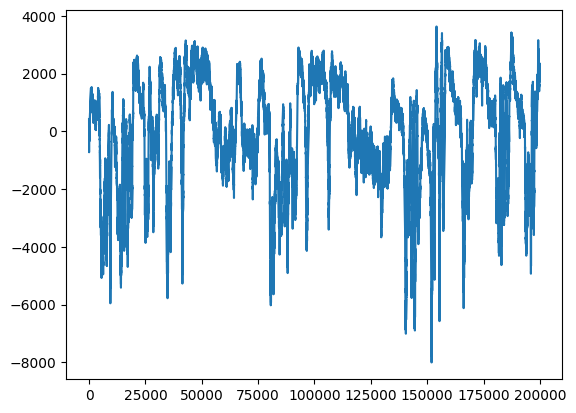

In [24]:
#rec.set_channel_gains(1)
traces_unscaled = rec.get_traces( channel_ids = [120], end_frame = 200000, return_scaled=False)
plt.plot(traces_unscaled)

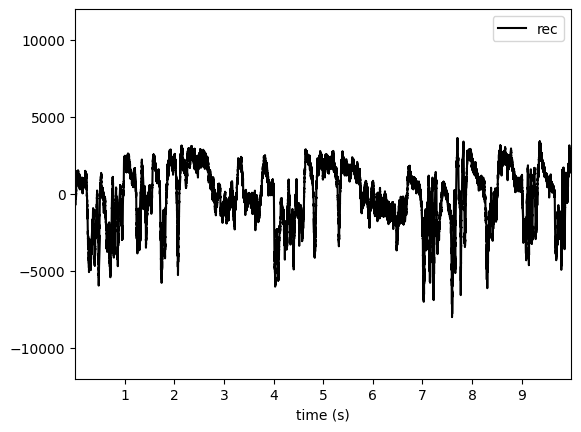

In [25]:
sw.plot_timeseries(rec, channel_ids = [120], time_range = [0,10])

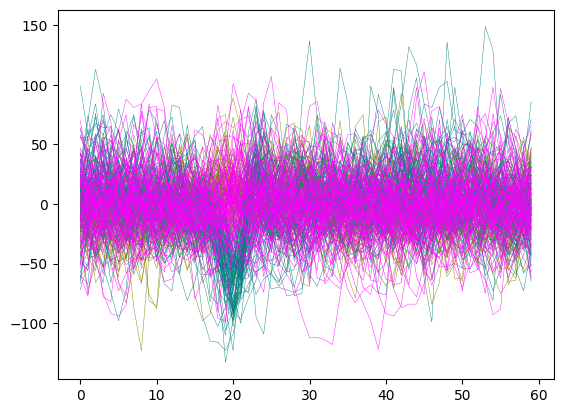

In [21]:
colors = ['Olive', 'Teal', 'Fuchsia']

fig, ax = plt.subplots()
for i, unit_id in enumerate(sorting.unit_ids[:3]):
    wf = we.get_waveforms(unit_id)
    color = colors[i]
    ax.plot(wf[:, :, 8].T, color=color, lw=0.3)

In [22]:
# Full depth runs on single sorters

In [23]:
rec.set_channel_gains(1)
recording_f = si.bandpass_filter(rec, freq_min=300, freq_max=6000)
recording_cmr = si.common_reference(recording_f, reference='global', operator='median')
rec_ready = recording_cmr

fullinpath = '/gpfs/bbp.cscs.ch/project/proj68/home/imbeni/SortingRunsMPI/1_horvath/r1ins1d1full/'
#sorters = list(ss.installed_sorters())
fullrecpath = fullinpath + 'recording000'
rec_ready.save(folder = fullrecpath, format='binary')

sorters = ['tridesclous2']

for sorter in sorters:
    pprint(sorter)
    params = fixparams(sorter)

    print('Running sorter')
    sorting = ss.run_sorter(sorter, recording = rec_ready, output_folder = fullinpath +str(sorter)+'_output', 
                            verbose = True, remove_existing_folder = True, delete_output_folder = False, **params)
    import shutil
    shutil.rmtree(fullinpath + str(sorter) + '_out_spiketrains')
    sorting.save(folder = fullinpath + str(sorter) + '_out_spiketrains')



AssertionError: folder /gpfs/bbp.cscs.ch/project/proj68/home/imbeni/SortingRunsMPI/1_horvath/r1ins1d1full/recording000 already exists, choose another name

In [ ]:
sorter = 'ironclust'

sortingpath = outpath + str(sorter) + '_out_spiketrains'

sorting = spikeinterface.load_extractor(sortingpath)

In [ ]:
sorting

In [ ]:
we_folder = output_folder + name +'/' + 'out_waveforms'

we = si.extract_waveforms(rec_ready, sorting, we_folder,
                          load_if_exists=False, overwrite=True,
                          ms_before=1, ms_after=2., max_spikes_per_unit=None)
pc = spost.compute_principal_components(we, n_components=3)
metrics = sqm.compute_quality_metrics(we)
nunits[length]=len(sorting.get_unit_ids())
allmetrics.append(metrics.mean(axis = 0))

print('Done!')


# more detailed analysis

In [ ]:

we = si.extract_waveforms(cam_rec_ready, sorting, we_folder,
                          load_if_exists=False, overwrite=True,
                          ms_before=1, ms_after=2., max_spikes_per_unit=None)
print(we)

In [ ]:
pc = spost.compute_principal_components(we, n_components=3)

unit_locations = spost.compute_unit_locations(we, method="monopolar_triangulation")
spike_locations = spost.compute_spike_locations(we, method="monopolar_triangulation")


In [ ]:
sw.plot_unit_locations(we)
sw.plot_spike_locations(we)

In [ ]:
ccgs, bins = spost.compute_correlograms(we)
sw.plot_autocorrelograms(we, unit_ids=sorting.unit_ids[:3])
sw.plot_crosscorrelograms(we, unit_ids=sorting.unit_ids[:3])


In [ ]:
metrics = sqm.compute_quality_metrics(we)
metrics.sort_values(by = 'num_spikes',  inplace = True, ascending = False)
metrics.reset_index(names = 'id', inplace = True)
pprint(metrics)

In [ ]:
for col in metrics.columns:
    sns.histplot(metrics[col], kde = True)
    plt.title(col)
    plt.show()

In [ ]:
metrics.mean(axis = 0)